# Notebook for Project 1

_Jonatan Haraldsson_ [jonhara@chalmers.se](mailto:jonhara@chalmers.se)

_Jesper Noord_ [noord@chalmers.se](mailto:noord@chalmers.se)



In [ ]:
# relevant modules for this notebook
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import emcee
import corner
import scipy
from scipy.stats import gamma, invgamma, t, norm, norminvgauss, mode, uniform
import seaborn as sns
import random
import sklearn
import scipy.constants as const


# LaTeX font

plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 16
plt.rcParams['font.size'] = font_size

c = const.speed_of_light *1e-3
G = const.gravitational_constant

np.random.seed(123)

**Importing the data from SCP 2.1 dataset and exploring data**

In [2]:
data_ = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
df = pd.DataFrame(data_[:,1:5])  # only keep z, mu, mu_err
df.columns = ["z", "mu", "mu_err", "unknown"]

df.head()

z = np.array(df['z'])
mu = np.array(df['mu'])
mu_err = np.array(df['mu_err'])

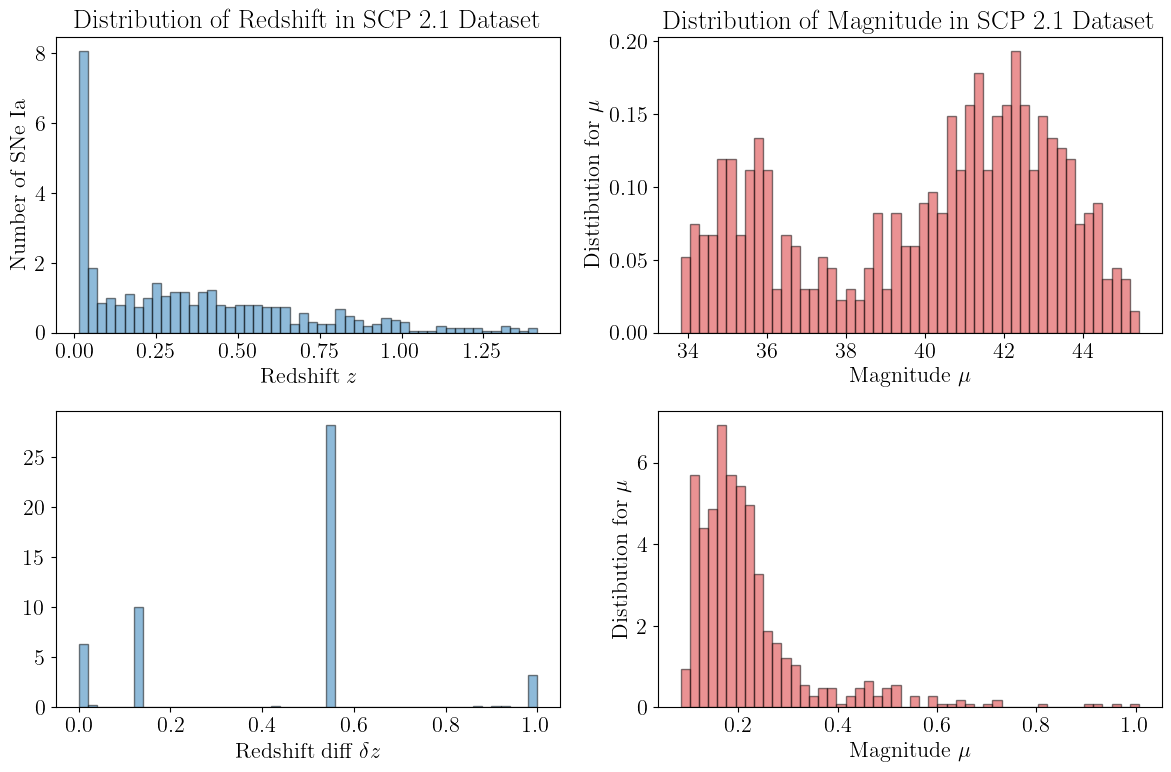

In [3]:
fig,ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].hist(z, bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
ax[0,0].set_xlabel('Redshift $z$')
ax[0,0].set_ylabel('Number of SNe Ia')
ax[0,0].set_title('Distribution of Redshift in SCP 2.1 Dataset')
ax[0,1].hist(mu, bins=50,density=True,color='tab:red',alpha=0.5,edgecolor='black')
ax[0,1].set_xlabel('Magnitude $\\mu$')
ax[0,1].set_ylabel('Disttibution for $\\mu$')
ax[0,1].set_title('Distribution of Magnitude in SCP 2.1 Dataset')
ax[0,1].set_xlabel('Magnitude $\\mu$')
ax[0,1].set_ylabel('Disttibution for $\\mu$')
ax[0,1].set_title('Distribution of Magnitude in SCP 2.1 Dataset')


ax[1,0].hist(df['unknown'], bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
ax[1,0].set_xlabel('Redshift diff $\\delta z$')
#ax[0,0].set_ylabel('Number of SNe Ia')
#ax[0,0].set_title('Distribution of Redshift in SCP 2.1 Dataset')
ax[1,1].hist(mu_err, bins=50,density=True,color='tab:red',alpha=0.5,edgecolor='black')
ax[1,1].set_xlabel('Magnitude $\\mu$')
ax[1,1].set_ylabel('Distibution for $\\mu$')
ax[1,1].set_xlabel('Magnitude $\\mu$')
ax[1,1].set_ylabel('Distibution for $\\mu$')

plt.tight_layout()
plt.show()

### Filtering in the small-$z$ region

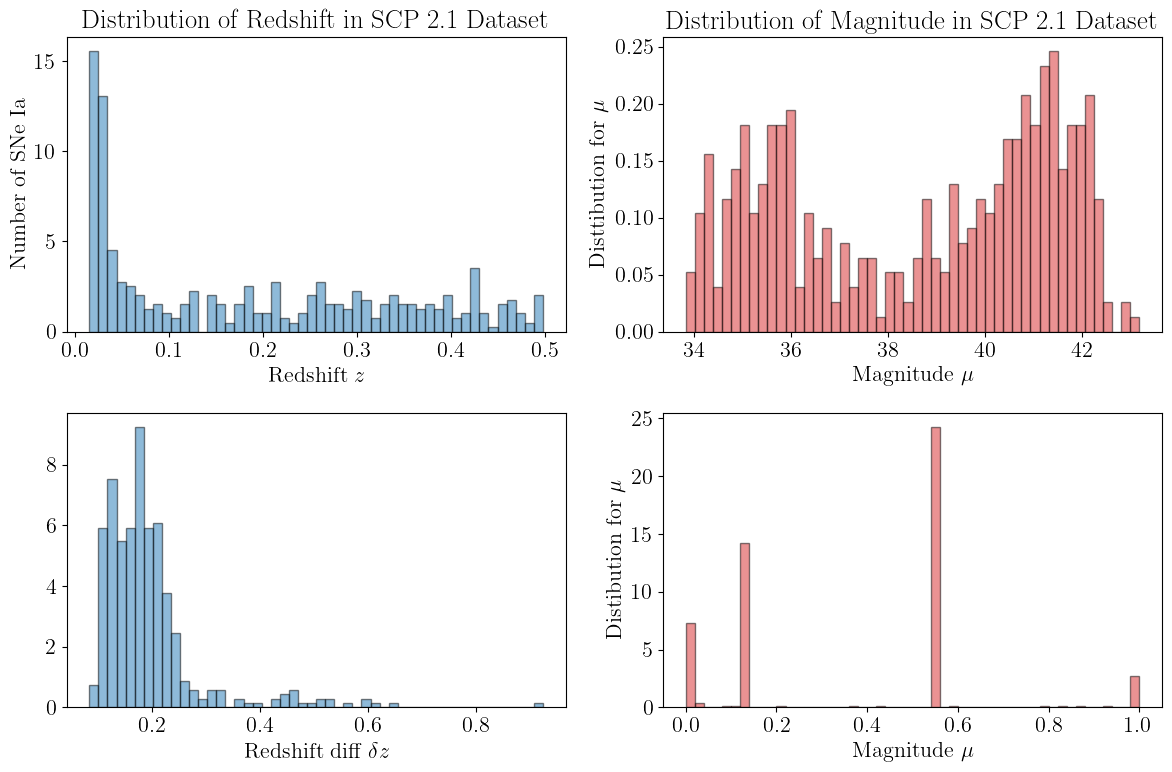

In [4]:
i = df['z'] < 0.5
z_low = np.array(df['z'][i])
mu_low = np.array(df['mu'][i])
mu_err_low = np.array(df['mu_err'][i])
unknown_low = np.array(df['unknown'][i])



fig,ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].hist(z_low, bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
ax[0,0].set_xlabel('Redshift $z$')
ax[0,0].set_ylabel('Number of SNe Ia')
ax[0,0].set_title('Distribution of Redshift in SCP 2.1 Dataset')
ax[0,1].hist(mu_low, bins=50,density=True,color='tab:red',alpha=0.5,edgecolor='black')
ax[0,1].set_xlabel('Magnitude $\\mu$')
ax[0,1].set_ylabel('Disttibution for $\\mu$')
ax[0,1].set_title('Distribution of Magnitude in SCP 2.1 Dataset')
ax[0,1].set_xlabel('Magnitude $\\mu$')
ax[0,1].set_ylabel('Disttibution for $\\mu$')
ax[0,1].set_title('Distribution of Magnitude in SCP 2.1 Dataset')


ax[1,0].hist(mu_err_low, bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
ax[1,0].set_xlabel('Redshift diff $\\delta z$')
#ax[0,0].set_ylabel('Number of SNe Ia')
#ax[0,0].set_title('Distribution of Redshift in SCP 2.1 Dataset')
ax[1,1].hist(unknown_low, bins=50,density=True,color='tab:red',alpha=0.5,edgecolor='black')
ax[1,1].set_xlabel('Magnitude $\\mu$')
ax[1,1].set_ylabel('Distibution for $\\mu$')
ax[1,1].set_xlabel('Magnitude $\\mu$')
ax[1,1].set_ylabel('Distibution for $\\mu$')

plt.tight_layout()
plt.show()

### Defining some useful functions  

In [ ]:
def mu_to_d(mu):
    return 10**((mu - 25) / 5)  # in Mpc

def d_to_mu(d):
    return 5 * np.log10(d) + 25

def rho_crit(H):
    return 3 * H**2 / (8 * np.pi * G)

def get_Om_lam(lam,H):
    return lam / (3 * H**2)

def get_Om_M(lam,H,Om_k = None):
    if Om_k is not None:
        return 1 - Om_k - get_Om_lam(lam,H)
    else:
        return 1 - get_Om_lam(lam,H)
    
def get_q0(Om_M,Om_lam):
    return Om_M / 2 - Om_lam

def get_dl(H_0,z,q_0):
    d = (c / H_0) * (z + (1-q_0) * z**2/2)
    return d

#def low_z_model(mu,z,q0):
    #d = dist_mod(mu)
    #H = (c / d) * (z + (1-q0) * z**2/2)
    #return H

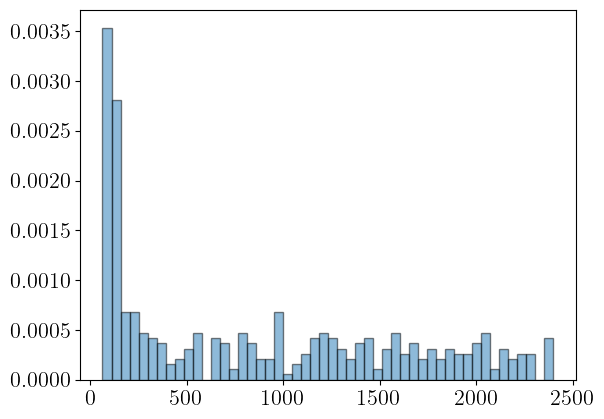

In [17]:
plt.hist(get_dl(70,z_low,0.5), bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
plt.show()

### Functions for distributions

In [7]:
def nig_log(th,s2,mu0,Sigma0,alpha,beta):

    if alpha<=0:
        print('error alpha<=0')
        return 0
    if beta<=0:
        print('error beta<=0')
        return 0

    NIG_log = norm.logpdf(th,loc=mu0,scale=np.sqrt(s2)*np.sqrt(Sigma0))+invgamma.logpdf(s2,a=alpha,scale=beta)

    return NIG_log
    
# helper function to convert the IG mean,mode to alpha,beta
def mean_mode_2_IG_alpha_beta(mean,mode):
    alpha = (mode + mean)/(mean-mode)
    beta = (2 * mode * mean)/(mean-mode)
    return alpha, beta


Your first task is to use $$d_L=\frac{c}{H_0}\left(z + \frac{1}{2}(1-q_0)z^2\right)$$ in the small-$z$ regime $(z < 0.5)$ to extract a joint probability
distribution for $H_0$ and $q_0$. You should use data weights proportional to the measurement errors,
and an inverse gamma prior for the unknown error scale $σ^2$. You can use e.g. uniform priors for
$H0$ and $q0$ if you like.

### $\log$-Prior, $\log$-Likelihood and $\log$-posterior 

Prior is given by $$\mathcal{U}_H[H_{min},H_{max}]\times\mathcal{U}_q[q_{min},q_{max}]\times \mathcal{IG}(\alpha,\beta,\sigma^2)$$

Likelihood's given by $$\cancel{\left( \frac{1}{2\pi} \right)^{N_d/2}} \frac{1}{|\Sigma_{\varepsilon}|^{1/2}} \exp \left[ -\frac{1}{2} (\mathcal{D} - \boldsymbol{y}_{model})^{T} \Sigma_{\varepsilon}^{-1} (\mathcal{D} - \boldsymbol{y}_{model}) \right],$$ where $$\Sigma_\varepsilon=\begin{bmatrix} \sigma^2_1 & \cdots       &        0 \\ \vdots&     \ddots   & 0  \\ 0      &        &      \sigma_n^2 \end{bmatrix}\quad\text{and}\quad\mathcal{D} = 10^{(\mu - 25)/5} \quad \text{and}\quad \boldsymbol{y}_{model}=\frac{c}{H_0}\left(z + \frac{1}{2}(1-q_0)z^2\right)$$

So the log-likelihood is then given by $$\left[ -\frac{1}{2} (\mathcal{D} - \boldsymbol{y}_{model})^{T} \Sigma_{\varepsilon}^{-1} (\mathcal{D} - \boldsymbol{y}_{model}) \right] - 0.5\det\{{\Sigma_\varepsilon}\}$$

In [40]:
def log_likelihood(theta, z, mu, sig_m):
    '''
    z - found in data frame
    mu - found in data frame
    sig_m - found in data frame
    '''
    H0 = theta[0]#.flatten()
    q0 = theta[1]#.flatten()
    sig2 = sig_m**2

    w = 1 / sig2 * (1 / len(mu))
    W = np.diag(w)
    
    y = mu
    model = d_to_mu(get_dl(H0,z,q0))
    
    log_like = -0.5 * (y - model).T @ W @ (y - model) + 0.5 * np.linalg.det(W)

    return log_like#, y[0], model[0]

def log_prior(theta):

    H0 = theta[0]#.flatten()
    q0  = theta[1]#.flatten()

    H0_min = 50; H0_max = 100
    q0_min = -5;  q0_max = 5
    sig2 = 10; a0 = 5; b0 = 5

    log_H = uniform.logpdf(H0, loc=H0_min, scale=H0_max - H0_min)

    log_q = uniform.logpdf(q0, loc = q0_min, scale = q0_max - q0_min)

    log_th = log_q + log_H

    log_IG = invgamma.logpdf(sig2,a=a0, scale=b0)  

    #log_N  = norm.logpdf(mu,loc=mu0[0],scale=np.sqrt(sig2)*Sigma0[0][0]**0.5)
    lp = log_IG+log_th
    
    return lp


def log_posterior(theta, z, mu, sig_m):

    log_like = log_likelihood(theta, z, mu, sig_m)
    log_pri = log_prior(theta)
    
    log_post = log_like + log_pri
    
    return log_post

'post_pdf = np.zeros_like(grid)\nfor th_idx, th_val in enumerate(H0):\n    for s2_idx, s2_val in enumerate(q0):\n        post_pdf[s2_idx][th_idx] = log_posterior([th_val,s2_val], z, mu, sig)'

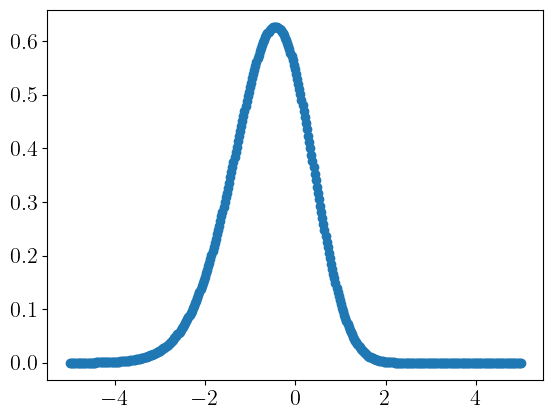

In [45]:
H0 = 70; q0 = 2


H0_grid = np.linspace(10,100,len(z_low))
q0_grid = np.linspace(-5,5,len(H0_grid))

H0, q0 = np.meshgrid(H0_grid,q0_grid)

HQ_grid = np.dstack((H0,q0))
grid = HQ_grid.reshape(-1,2)



z = z_low
mu = mu_low
sig = mu_err_low

#z = unknown_low

n = 0
for q_i in q0_grid:
    like = log_likelihood([70,q_i], z, mu, sig)
    #plt.scatter(q_i,y1,color='tab:blue')
    #plt.scatter(q_i,m1,color='tab:red')
    plt.scatter(q_i,np.exp(like),color='tab:blue')
    #print(like)
    n += 1
"""post_pdf = np.zeros_like(grid)
for th_idx, th_val in enumerate(H0):
    for s2_idx, s2_val in enumerate(q0):
        post_pdf[s2_idx][th_idx] = log_posterior([th_val,s2_val], z, mu, sig)"""
        


#plt.contourf(H0, q0, post_pdf, levels=200, cmap='Blues')#,alpha=0.5)

#print(log_posterior(th,z,mu,sig))


In [60]:
H0 = 70; q0 = 2


H0_grid = np.linspace(10,100,len(z_low))
q0_grid = np.linspace(-5,5,len(H0_grid))

H0, q0 = np.meshgrid(H0_grid,q0_grid)

HQ_grid = np.dstack((H0,q0))
grid = HQ_grid.reshape(-1,2)

z = z_low
mu = mu_low
sig = mu_err_low

n = 0
for q_i in q0_grid:
    prior = log_prior([70,q_i])
    #plt.scatter(q_i,y1,color='tab:blue')
    #plt.scatter(q_i,m1,color='tab:red')
    #plt.scatter(q_i,prior,color='tab:blue')
    #print(prior)
    print(log_posterior([70,q_i],z,mu,sig))
    n += 1



        
# prior_pdf = np.zeros((len(H0_grid),len(q0_grid)))
# for H_i,H_val in enumerate(H0_grid):
#     for q_i,q_val in enumerate(q0_grid):
#         prior_pdf[q_i][H_i] = log_posterior([H_val,q_val],z,mu,sig)

# plt.contourf(H0, q0, np.exp(prior_pdf) , levels=200, cmap='Blues')#,alpha=0.5)

#print(log_posterior(th,z,mu,sig))


-24.932682204206202
-24.85616322899159
-24.779840381240085
-24.70371493706933
-24.62778818217238
-24.55206141190801
-24.476535931392057
-24.4012130555898
-24.326094109409432
-24.251180427796612
-24.17647335583019
-24.10197424881893
-24.02768447239945
-23.95360540263534
-23.879738426117402
-23.80608494006502
-23.732646352428905
-23.659424081994885
-23.586419558488963
-23.51363422268378
-23.441069526506137
-23.368726933145968
-23.29660791716654
-23.224713964615976
-23.15304657314021
-23.081607252097218
-23.010397522672687
-22.939418917997052
-22.868672983264
-22.798161275850404
-22.727885365437736
-22.65784683413495
-22.58804727660289
-22.51848830018024
-22.449171525011042
-22.380098584173737
-22.31127112381193
-22.2426908032666
-22.174359295210195
-22.106278285782164
-22.03844947472641
-21.970874575530253
-21.90355531556542
-21.83649343623051
-21.769690693095512
-21.703148856048024
-21.63686970944141
-21.570855052244767
-21.505106698194922
-21.43962647595026
-21.37441622924664
-21.30947

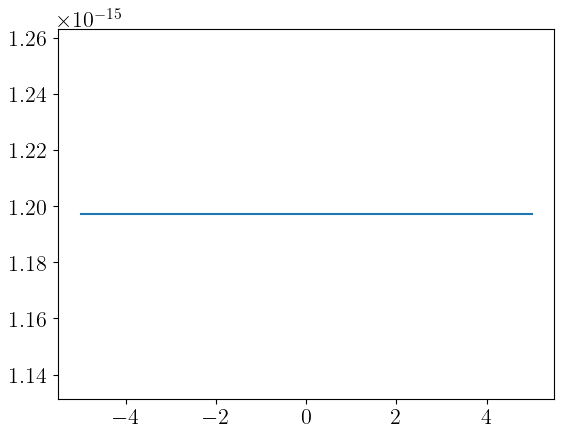

In [55]:
plt.plot(q0_grid,np.exp(log_posterior([70,q0_grid],z,mu,sig)))
plt.show()

### MCMC sampling
Here we go again!! 

In [61]:
def samples_MCMC(q0_lims, H0_lims, post,x, y, sigma ,nwalkers, burninproc =10 , iterations = 10000):
    """
    Sets up an MCMC sampler with initial positions for the walkers.

    Args:
        theta_0_lims (list): Minimum and maximum boundary for starting position in theta0.
        theta_1_lims (list): Minimum and maximum boundary for starting position in theta1.
        x (array): Independent data.
        y (array): Dependent data.
        post (callable): Function to compute the log-posterior or log-likelihood.
        nwalkers (int): Number of MCMC walkers.

    Returns:
        sampler (emcee.EnsembleSampler): Initialized MCMC sampler object.
    """
    
    ndim = 3  # Since theta has three parameters: [intercept, slope,sigma]

    rng = np.random.default_rng(seed = 1337)


    q   = rng.uniform(q0_lims[0],q0_lims[1],size = nwalkers)
    H   = rng.uniform(H0_lims[0],H0_lims[1],size = nwalkers)
    sig_e = rng.uniform(5,50,size = nwalkers)

    p0 = np.vstack((q,H,sig_e)).T

    burnin = burninproc*iterations/100

    # Set up the MCMC sampler with the log posterior function
    sampler_post = emcee.EnsembleSampler(nwalkers, ndim, post, args = (x, y, sigma))
    new_pos, prob, state = sampler_post.run_mcmc(p0, burnin, progress=True)

    run = sampler_post.run_mcmc(new_pos, iterations)#, progress=True)
    samples = sampler_post.get_chain(discard = burnin,flat = True)

    return samples

In [62]:

x = z_low
y = mu_low
sig = mu_err_low**2

H0_lims = [10,100]
q0_lims = [-10,10]

samples = samples_MCMC(H0_lims,q0_lims,log_posterior,x,y,
                                 sigma = sig,iterations=int(1e3),nwalkers=10)

/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_9018/639033388.py:5: RuntimeWarning: invalid value encountered in log10
  return 5 * np.log10(d) + 25


ValueError: Probability function returned NaN

In [117]:
print('Number of samples',len(samples))

Number of samples 10000


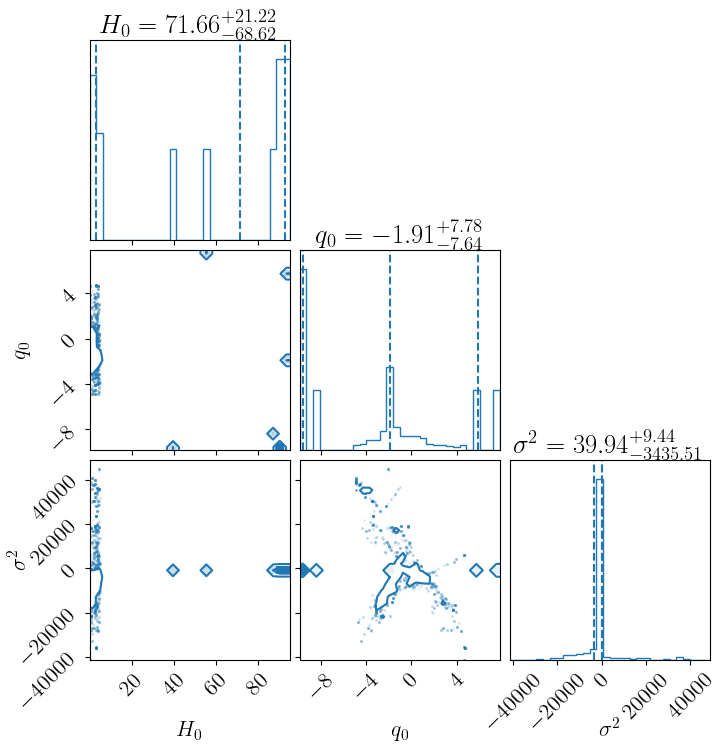

In [120]:
fig = corner.corner(samples, labels=[r"$H_0$", r"$q_0$",r"$\sigma^2$"], color='tab:blue',
                show_titles=True, bins=30, plot_contours=True, plot_datapoints=True, 
                plot_density=True,quantiles=[0.16,0.5,0.84])#,truths = [intercept,slope,sigma])